# Защита данных клиентов

## Описание проекта
Необходимо защитить данные клиентов страховой компании. Надо разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию, и затем обосновать корректность его работы.
Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## 1. Загрузка данных

Импортируем нужные модули, затем загрузим и выведем информацию о них.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

data = pd.read_csv('/datasets/insurance.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Пропусков в данных у нас нет, но неплохо было бы перевести данные в колонках `Пол` и `Возраст` в int, эти значения должны быть целочисленными.

In [2]:
data[['Возраст', 'Зарплата']] = data[['Возраст', 'Зарплата']].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null int64
Зарплата             5000 non-null int64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: int64(5)
memory usage: 195.4 KB


Посмотрим распределения данных в столбцах.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3107560d0>,
      dtype=object)

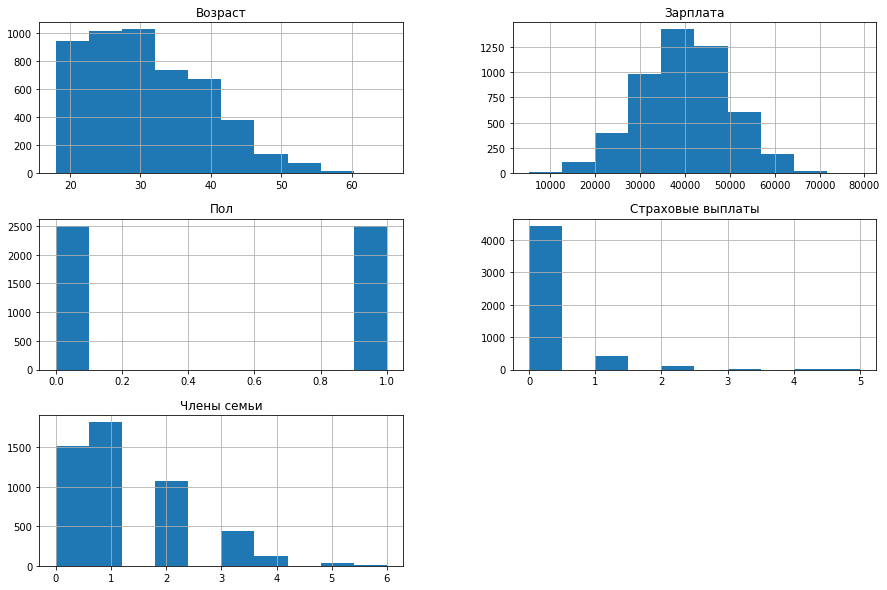

In [3]:
data.hist(figsize=(15, 10))

Как можно заметить, нормальному распределению соответствуют только данные в столбце `Зарплата`.

**Вывод:** проблем с данными нет, предобработка почти не понадобилась. Переходим к следующему шагу.

## 2. Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$


**Вопрос:** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)
    
Если в задаче линеной регрессии $a = Xw$ умножить $X (M, N)$ на обратимую матрицу $Z$, размерности $(N, N)$, то при вычислении весов $w = (X^T X)^{-1} X^T y$ предсказания $a$ не дожны изменится.

**Ответ:** предсказания $a$ не изменяться.

**Обоснование:**

Для доказательства, подставим вместо $X$ $XZ$. Дополнительно, допустим, что $X^TX$ — обратима.

$$
a_{new} = XZw_{new}
$$

$$
w_{new} = ((XZ)^T XZ)^{-1}(XZ)^T y
$$

Подставим $w_{new}$ в $a_{new}$ и преобразуем:

$$
a_{new} = X Z ((XZ)^T XZ)^{-1}(XZ)^T y = \\X Z (Z^TX^T XZ)^{-1}Z^T X^T y = \\X Z (X^TXZ)^{-1} (Z^T)^{-1} Z^T X^T y = \\X Z Z^{-1}(X^TX)^{-1} (Z^T)^{-1} Z^T X^T y = \\X E (X^TX)^{-1} E  X^T y = \\X (X^TX)^{-1} X^T y =  X w
$$

Пояснения:
1. Раскрываем транспонирования по свойству: $(AB)^T = B^T A^T$
2. Считаем, что $X^TX$ - квадратная обратимая марица, $Z$ - обратимая по опеределению, то раскрываем скобки по свойству $(AB)^{-1} = B^{-1} A^{-1}$ 2 раза.
3. Используя ассоциативность умножения матриц и определение обратной матрицы, получаем ответ.

Таким образом, получается, что:

$$
a_{new} = a
$$

**Вывод:** возможность умножения признаков на обратимую матрицу без потери качества предсказания доказана.

## 3. Алгоритм преобразования

Напишем алгоритм преобразования данных. Наш алгоритм будет умножать признаки на обратимую матрицу, так как при умножении будет терятся возможность расшифровки данных. Для бизнеса этот алгоритм понадобиться, чтобы данные клиентов были защищены, чтобы их не смогли украсть злоумышленники.

**Алгоритм:**

In [4]:
def algorithm(data):
    features = data.drop(['Страховые выплаты'], axis = 1)
    target = data['Страховые выплаты']
    features = features.values
    target = target.values  
    P = np.random.randint(0, 10, (features.shape[1], features.shape[1]))
    X = features.dot(P)
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

    model = LinearRegression()
    model.fit(features_train, target_train)
    predict = model.predict(features_valid)
    display('Метрика R2 до преобразования:')
    display(r2_score(target_valid, predict))
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    X, target, test_size=0.25, random_state=12345)
    
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predict = model.predict(features_valid)
    display('Метрика R2 после преобразования:')
    display(r2_score(target_valid, predict))

**Обоснование:**

In [5]:
features = data.drop(['Страховые выплаты'], axis = 1)
target = data['Страховые выплаты']
features = features.values
target = target.values
P = np.random.randint(0, 10, (features.shape[1], features.shape[1]))
np.linalg.inv(P)

array([[ 0.30612245, -0.06122449, -0.18367347,  0.02040816],
       [-0.44260204,  0.30102041,  0.09056122, -0.05867347],
       [-0.26020408,  0.10204082,  0.05612245,  0.13265306],
       [ 0.37244898, -0.2244898 ,  0.07653061, -0.09183673]])

In [6]:
X = features.dot(P)
X

array([[ 99579, 198732, 347501, 397096],
       [ 76418, 152368, 266331, 304325],
       [ 42261,  84232, 147203, 168203],
       ...,
       [ 67988, 135760, 237458, 271346],
       [ 65616, 130980, 229086, 261769],
       [ 81462, 162628, 284410, 325005]])

В таком виде, невозможно понять, какие именно данные несёт в себе матрица.

In [7]:
features_train, features_valid, target_train, target_valid = train_test_split(
    X, target, test_size=0.25, random_state=12345)
model = LinearRegression()
model.fit(features_train, target_train)
predict = model.predict(features_valid)
r2_score(target_valid, predict)

0.4352275684082837

**Вывод:** алгоритм работает правильно.

## 4. Проверка алгоритма

Проверим, измениться ли качество линейной регрессии при умножении признаков на обратимую матрицу.
Проверим линейную регрессию из `sklearn`.

In [8]:
features = data.drop(['Страховые выплаты'], axis = 1)
target = data['Страховые выплаты']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [9]:
model = LinearRegression()
model.fit(features_train, target_train)
predict = model.predict(features_valid)
r2_score(target_valid, predict)

0.4352275684083349

Затем, проверим с переводом данных в векторный формат и умножением признаков на обратимую матрицу.

In [10]:
features_array, target_array = features.values, target.values
features_train_array, features_valid_array, target_train_array, target_valid_array = train_test_split(
    features_array, target_array, test_size=0.25, random_state=12345)

factor = np.random.randint(0, 10, (features_train_array.shape[1], features_train_array.shape[1]))
factor = np.linalg.inv(factor)
factor

array([[ -24. ,   32.5,  -17. ,   20. ],
       [  17. ,  -23. ,   12. ,  -14. ],
       [ 140. , -188.5,   98. , -116. ],
       [ -23. ,   31. ,  -16. ,   19. ]])

In [11]:
features_train_array = features_train_array.dot(factor)
features_valid_array = features_valid_array.dot(factor)

In [12]:
model_array = LinearRegression()
model_array.fit(features_train_array, target_train_array)
predict_array = model_array.predict(features_valid_array)
r2_score(target_valid_array, predict_array)

0.43522756844084665

Теперь, проверим это на собственно написанных методах, сначала с обычными данными.

In [13]:
features_self = data.drop(['Страховые выплаты'], axis = 1)
target_self = data['Страховые выплаты']
features_train_self, features_valid_self, target_train_self, target_valid_self = train_test_split(
    features_self, target_self, test_size=0.25, random_state=12345)

In [14]:
class LinearRegression_self:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = ((np.linalg.inv(X.T @ X)) @ X.T) @ y
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [15]:
model_self = LinearRegression_self()
model_self.fit(features_train_self, target_train_self)
predictions_self = model_self.predict(features_valid_self)
r2_score(target_valid_self, predictions_self)

0.43522756840833376

И с умноженными на обратимую матрицу.

In [16]:
factor_self = np.random.randint(0, 10, (features_self.shape[1], features_self.shape[1]))
factor_self_inv = np.linalg.inv(factor_self)
factor_self_inv

array([[ 0.15319149,  0.32340426, -0.42978723, -0.26808511],
       [ 0.36595745,  0.21702128, -0.74893617, -0.14042553],
       [ 0.32765957,  0.13617021, -0.39148936, -0.32340426],
       [-0.60425532, -0.49787234,  1.30638298,  0.55744681]])

In [17]:
features_self = features_self.dot(factor_self)
features_train_self, features_valid_self, target_train_self, target_valid_self = train_test_split(
    features_self, target_self, test_size=0.25, random_state=12345)

In [18]:
model_self = LinearRegression_self()
model_self.fit(features_train_self, target_train_self)
predictions_self = model_self.predict(features_valid_self)
r2_score(target_valid_self, predictions_self)

0.4352275379451279

Проверим алгоритм преобразования на нашем датасете.

In [19]:
algorithm(data)

'Метрика R2 до преобразования:'

0.4352275684083349

'Метрика R2 после преобразования:'

0.4352275684083491

Дополнительно проверим алгоритм в цикле, чтобы посмотреть, не меняется ли R2 от случайной матрицы к случайной матрице.

In [20]:
for i in range(1, 6):
    algorithm(data)

'Метрика R2 до преобразования:'

0.4352275684083349

'Метрика R2 после преобразования:'

0.4352275684083212

'Метрика R2 до преобразования:'

0.4352275684083349

'Метрика R2 после преобразования:'

0.43522756840797117

'Метрика R2 до преобразования:'

0.4352275684083349

'Метрика R2 после преобразования:'

0.43522756840899157

'Метрика R2 до преобразования:'

0.4352275684083349

'Метрика R2 после преобразования:'

0.4352275684083998

'Метрика R2 до преобразования:'

0.4352275684083349

'Метрика R2 после преобразования:'

0.4352275684085194

**Вывод:** не меняется, алгоритм написан успешно.